
===== BASELINE MODEL PERFORMANCE =====
Baseline AUC: 0.7493734335839599
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        19
           1       0.76      0.76      0.76        21

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}

===== FINAL MODEL PERFORMANCE =====
AUC: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        21

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


Ge

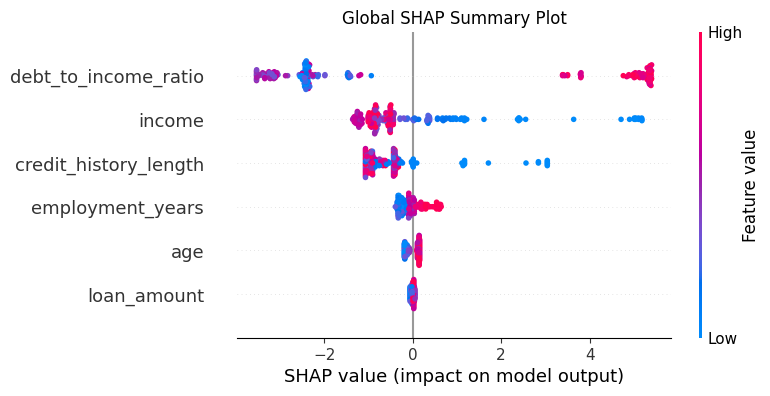


Generating SHAP waterfall plots for top 10 high-risk borrowers...

Waterfall plot for high-risk customer #1


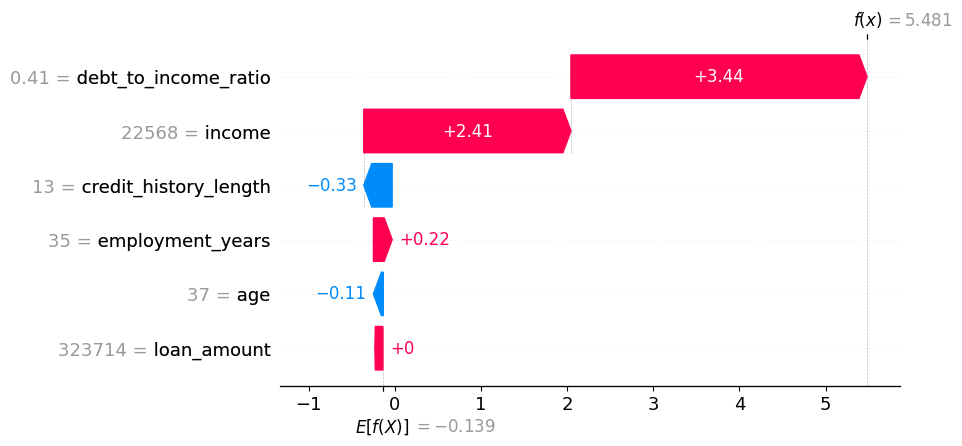


Waterfall plot for high-risk customer #2


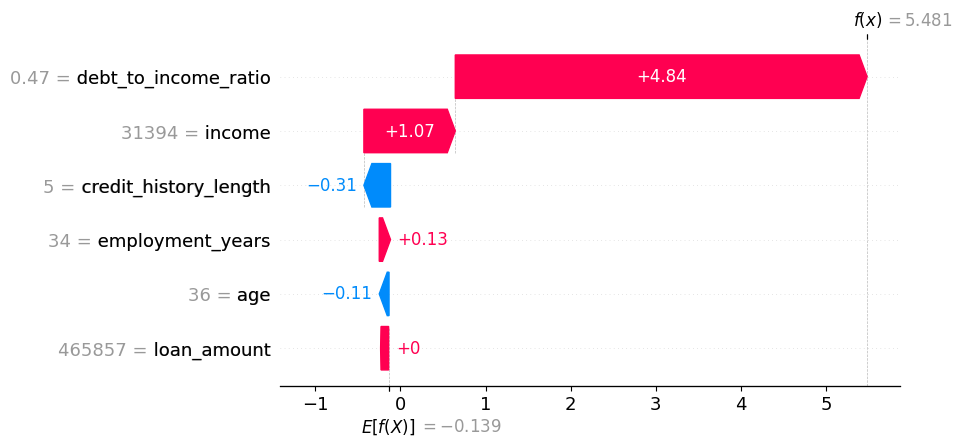


Waterfall plot for high-risk customer #3


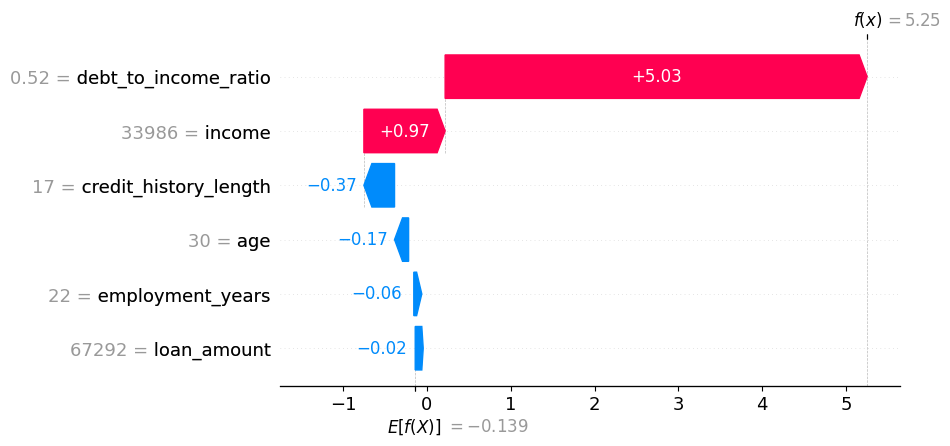


Waterfall plot for high-risk customer #4


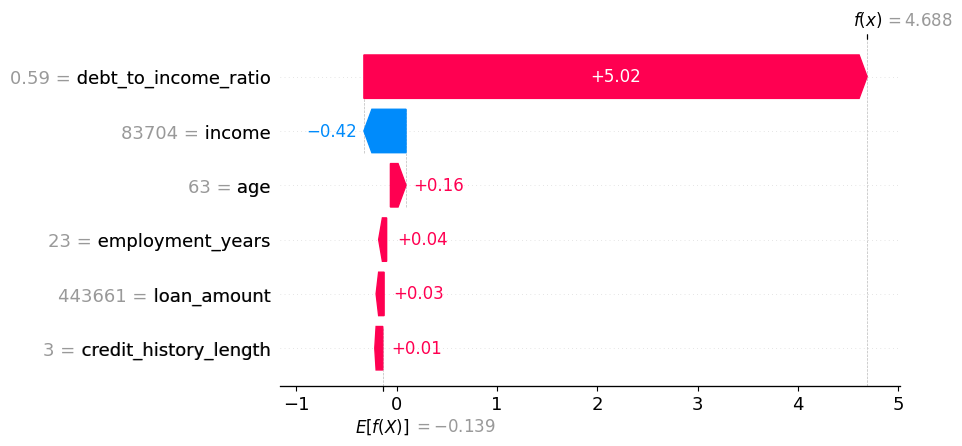


Waterfall plot for high-risk customer #5


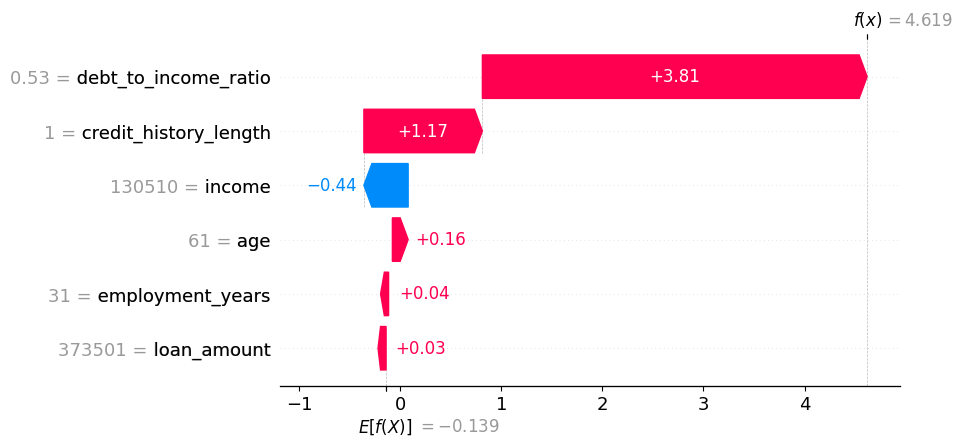


Waterfall plot for high-risk customer #6


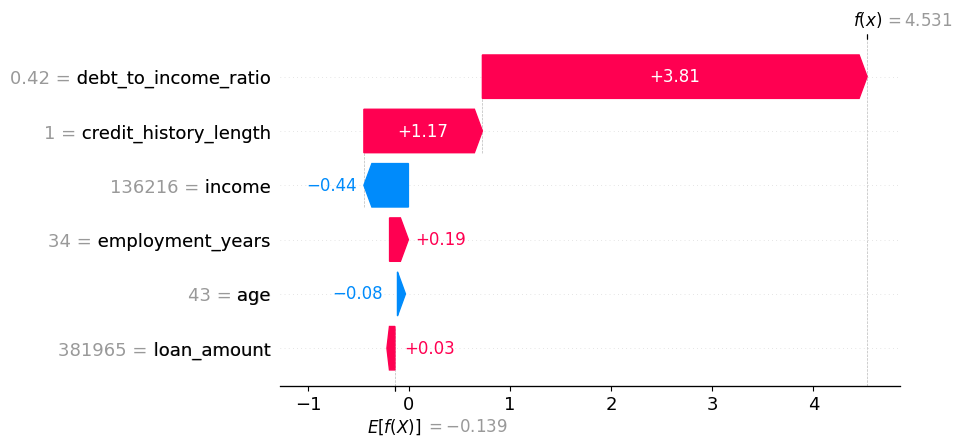


Waterfall plot for high-risk customer #7


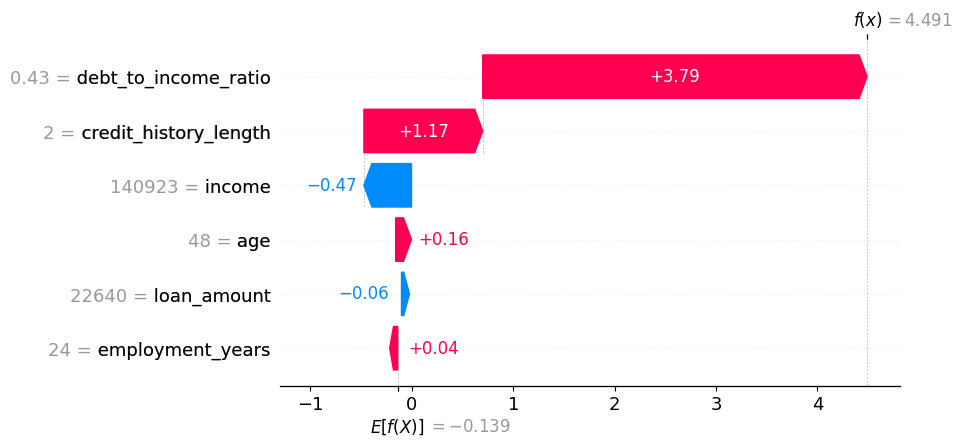


Waterfall plot for high-risk customer #8


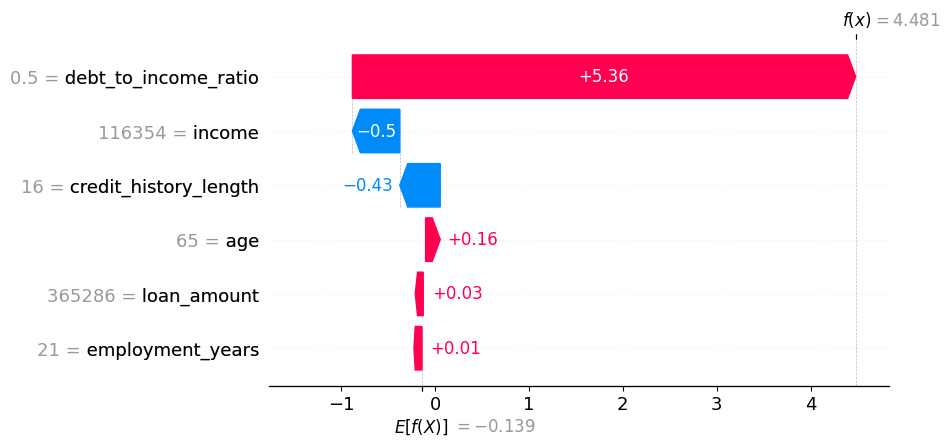


Waterfall plot for high-risk customer #9


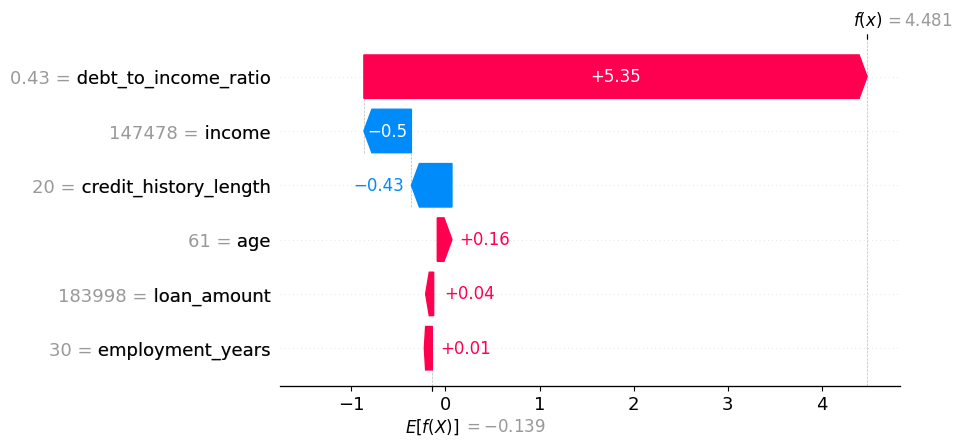


Waterfall plot for high-risk customer #10


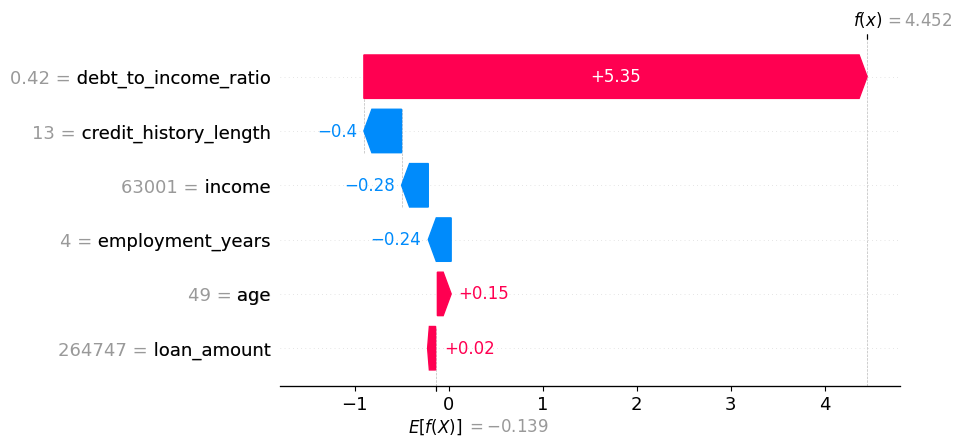


Generating SHAP dependence plots...


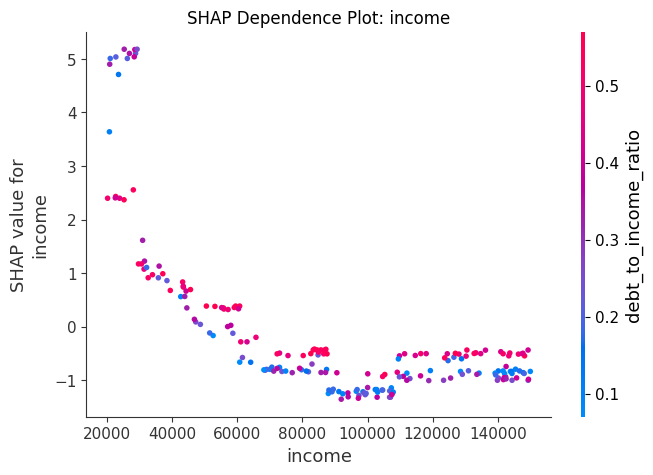

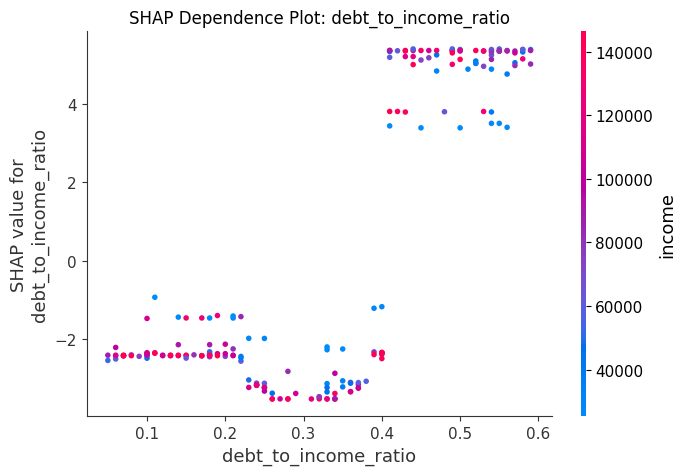


===== ALL TASKS COMPLETED SUCCESSFULLY =====


In [2]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

from xgboost import XGBClassifier


# Enable JS visualization for SHAP
shap.initjs()


# ============================================================
# 2. LOAD DATA
# ============================================================
df = pd.read_csv("/content/credit_risk_dataset.csv")

X = df.drop("default", axis=1)
y = df["default"]


# ============================================================
# 3. TRAIN-TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ============================================================
# 4. SCALING
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ============================================================
# 5. BASELINE MODEL — Logistic Regression
# ============================================================
from sklearn.linear_model import LogisticRegression
baseline = LogisticRegression()
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)

print("\n===== BASELINE MODEL PERFORMANCE =====")
print("Baseline AUC:", roc_auc_score(y_test, baseline_pred))
print(classification_report(y_test, baseline_pred))


# ============================================================
# 6. FINAL MODEL — XGBOOST WITH GRID SEARCH
# ============================================================
xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

params = {
    "n_estimators": [150, 200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)


# ============================================================
# 7. FINAL MODEL EVALUATION
# ============================================================
pred = best_model.predict(X_test)

auc = roc_auc_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print("\n===== FINAL MODEL PERFORMANCE =====")
print("AUC:", auc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(y_test, pred))


# ============================================================
# 8. SHAP EXPLAINER
# ============================================================
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)


# ============================================================
# 9. GLOBAL SHAP SUMMARY PLOT
# ============================================================
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X, show=False)
plt.title("Global SHAP Summary Plot")
plt.show()


# ============================================================
# 10. SHAP LOCAL EXPLANATIONS (TOP 10 HIGH-RISK)
# ============================================================
# Identify top 10 predicted defaulters
X_test_copy = X_test.copy()
X_test_copy["pred_default_prob"] = best_model.predict_proba(X_test)[:, 1]
top10 = X_test_copy.sort_values("pred_default_prob", ascending=False).head(10)

print("\nGenerating SHAP waterfall plots for top 10 high-risk borrowers...")

for i, idx in enumerate(top10.index):
    print(f"\nWaterfall plot for high-risk customer #{i+1}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value,
            data=X.loc[idx],
            feature_names=X.columns
        ),
        max_display=10
    )


# ============================================================
# 11. SHAP DEPENDENCE PLOTS
# ============================================================
features_to_plot = [
    "income",
    "debt_to_income_ratio",
    # Add more if dataset includes them:
    # "age", "credit_history_length"
]

print("\nGenerating SHAP dependence plots...")

for feature in features_to_plot:
    shap.dependence_plot(
        feature,
        shap_values,
        X,
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feature}")
    plt.show()


print("\n===== ALL TASKS COMPLETED SUCCESSFULLY =====")
